In [ ]:
!git clone https://github.com/harancho/food-image-classifier.git
!pip install -U keras-tuner
!pip install split-folders

#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
#!tar xzvf food-101.tar.gz

Cloning into 'food-image-classifier'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 5073 (delta 14), reused 66 (delta 14), pack-reused 5007
Receiving objects: 100% (5073/5073), 265.65 MiB | 43.75 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (5043/5043), done.
     |████████████████████████████████| 71kB 7.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=8bedd851cddc9c464541ad17da72515832e026a989043b9c66126e676729ff3f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=a20178e18b5df7414ad83fbc4fc56e91b888180f9903665a21759faf9dc162d5
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfu

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import shutil
import splitfolders
# shutil.rmtree('food-image-classifier/dataset/.ipynb_checkpoints')

In [ ]:
splitfolders.ratio('food-image-classifier/dataset/', output='output', seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 5000 files [00:01, 4680.50 files/s]


In [ ]:
# datasets directories
train_data_dir = 'output/train/'   #'food-101/images/'
val_data_dir = 'output/val/'
batch_size = 16

# Rescaling images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest',
    horizontal_flip=True) 

validation_datagen = ImageDataGenerator(rescale=1./255)           

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(300,300),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical') 

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir, 
    target_size=(300,300),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical') 

Found 4000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [ ]:
def build_model():
    model = tf.keras.models.Sequential([
                                        
        # This is the first convolution                                
        tf.keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(300, 300, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # The second convolution
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # The third convolution
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # The fourth convolution
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),

        # Output layer
        tf.keras.layers.Dense(5, activation='softmax')
                                      
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [ ]:
model = build_model()
my_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,  
            epochs=30,
            validation_data = validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            callbacks=[my_callbacks]
            )

Epoch 1/30
250/250 [==============================] - 89s 356ms/step - loss: 1.6050 - accuracy: 0.2245 - val_loss: 1.5396 - val_accuracy: 0.3327
Epoch 2/30
250/250 [==============================] - 88s 353ms/step - loss: 1.4798 - accuracy: 0.3293 - val_loss: 1.4091 - val_accuracy: 0.3306
Epoch 3/30
250/250 [==============================] - 88s 352ms/step - loss: 1.4416 - accuracy: 0.3523 - val_loss: 1.3901 - val_accuracy: 0.3710
Epoch 4/30
250/250 [==============================] - 89s 356ms/step - loss: 1.4082 - accuracy: 0.3820 - val_loss: 1.3511 - val_accuracy: 0.4113
Epoch 5/30
250/250 [==============================] - 90s 361ms/step - loss: 1.3617 - accuracy: 0.4252 - val_loss: 1.3230 - val_accuracy: 0.4395
Epoch 6/30
250/250 [==============================] - 91s 364ms/step - loss: 1.3042 - accuracy: 0.4597 - val_loss: 1.2585 - val_accuracy: 0.4778
Epoch 7/30
250/250 [==============================] - 93s 370ms/step - loss: 1.2351 - accuracy: 0.4942 - val_loss: 1.1950 - val_ac

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'output/test/',
        target_size=(300, 300),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

predict = model.evaluate(test_generator,verbose=0)
print("Loss: {}\nAccuracy: {}%".format(round(predict[0],2),round(predict[1]*100,1)))

Found 500 images belonging to 5 classes.
Loss: 0.95
Accuracy: 68.4%


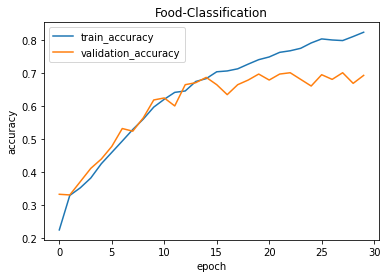

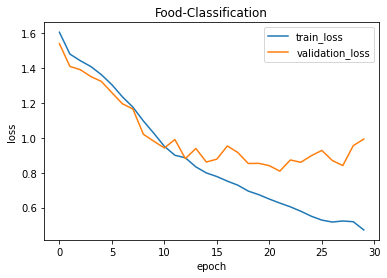

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

plot_accuracy(history,'Food-Classification')
plot_loss(history,'Food-Classification')


## Random Search for HyperParameter tuning

In [ ]:
def build_model_search(hp):
    model = tf.keras.models.Sequential([
                                        
        # This is the first convolution                                
        tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter',min_value=32,max_value=128,step=16),kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        # The second convolution
        tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter',min_value=32,max_value=128,step=16),kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # The third convolution
        tf.keras.layers.Conv2D(filters=hp.Int('conv_3_filter',min_value=32,max_value=128,step=16),kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # The fourth convolution
        tf.keras.layers.Conv2D(filters=hp.Int('conv_4_filter',min_value=32,max_value=128,step=16),kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),

        # 512 neuron hidden layer
        tf.keras.layers.Dense(units=hp.Int('dense_1_units',min_value=128,max_value=1024,step=64), activation='relu'),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(units=hp.Int('dense_2_units',min_value=128,max_value=1024,step=64), activation='relu'),

        # Output layer
        tf.keras.layers.Dense(5, activation='softmax')
                                      
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [ ]:
tuner_search=RandomSearch(build_model_search,objective='val_accuracy',max_trials=5,directory='output',project_name="Foods")

In [ ]:
tuner_search.search(train_generator,steps_per_epoch=125,epochs=3,validation_data=validation_generator)

In [ ]:
model1 = tuner_search.get_best_models(1)[0]
model1.summary()